In [50]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [55]:
subscribers_data = pd.read_csv('subscriber_data_2023-05-13.csv', index_col=0)

### Обзор данных

Посмотрим на датасет с подписчиками

In [56]:
display(subscribers_data.head())
display(subscribers_data.info())

,id,sex,bdate,city,university,graduation,is_closed,group_name
0,1378,1,2.2,Санкт-Петербург,СПбГУ,2010.0,True,Библиотеки Приморского района
1,2006,1,18.8.1984,Санкт-Петербург,СПбГУКИ,2006.0,True,Библиотеки Приморского района
2,3269,2,26.12.1986,Санкт-Петербург,NaN,NaN,True,Библиотеки Приморского района
3,3326,2,6.5.1986,Санкт-Петербург,СПбГЭТУ (ЛЭТИ),2009.0,False,Библиотеки Приморского района
4,3357,1,13.8,Санкт-Петербург,NaN,NaN,False,Библиотеки Приморского района


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10981 entries, 0 to 10980
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          10981 non-null  int64  
 1   sex         10981 non-null  int64  
 2   bdate       8326 non-null   object 
 3   city        9243 non-null   object 
 4   university  5185 non-null   object 
 5   graduation  3673 non-null   float64
 6   is_closed   10981 non-null  bool   
 7   group_name  10981 non-null  object 
dtypes: bool(1), float64(1), int64(2), object(4)
memory usage: 697.0+ KB


None

Сразу исправим значения в колонке "sex", на более понятные

In [53]:
subscribers_data['sex'] = subscribers_data['sex'].map({1: 'female', 2: 'male'})
subscribers_data.head()

,id,sex,bdate,city,university,graduation,is_closed,group_name
0,1378,female,2.2,Санкт-Петербург,СПбГУ,2010.0,True,Библиотеки Приморского района
1,2006,female,18.8.1984,Санкт-Петербург,СПбГУКИ,2006.0,True,Библиотеки Приморского района
2,3269,male,26.12.1986,Санкт-Петербург,NaN,NaN,True,Библиотеки Приморского района
3,3326,male,6.5.1986,Санкт-Петербург,СПбГЭТУ (ЛЭТИ),2009.0,False,Библиотеки Приморского района
4,3357,female,13.8,Санкт-Петербург,NaN,NaN,False,Библиотеки Приморского района


Количество уникальных пользователей, подписанных на несколько групп

In [5]:
subscribers_data[subscribers_data.duplicated(subset='id')].id.nunique()

1051

Количество дубликатов

In [6]:
subscribers_data[subscribers_data.duplicated(subset='id')].id.count()

1703

Сохраним уникальных подписчиков в отдельный датасет, чтобы было проще работать

In [7]:
subs_unique = subscribers_data.drop_duplicates(subset='id').copy()
subs_unique.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9278 entries, 0 to 10980
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          9278 non-null   int64  
 1   sex         9275 non-null   object 
 2   bdate       7090 non-null   object 
 3   city        7792 non-null   object 
 4   university  4374 non-null   object 
 5   graduation  3100 non-null   float64
 6   is_closed   9278 non-null   bool   
 7   group_name  9278 non-null   object 
dtypes: bool(1), float64(1), int64(1), object(5)
memory usage: 588.9+ KB


Количество собранных даных по каждой группе

In [8]:
subscribers_data.group_name.value_counts()

Библиотеки Приморского района                      3260
Библиотека Салтыкова-Щедрина                       1945
Библиотека № 9 Приморский район                    1643
Библиотека  на  Торжковской                        1399
Библиотека №7  Приморского района                   970
Библиотека Лисий Нос                                632
Библиотека№8 Приморский район                       520
Библиотека №4 в Ольгино                             448
Библиотека № 3 Приморского района С.-Петербурга     164
Name: group_name, dtype: int64



---



## Пол

#### Распределение среди всех групп

Посчитаем распределение по полу среди подписчиков всех групп

In [9]:
pd.concat([subs_unique.sex.value_counts(),
                subs_unique.sex.value_counts(normalize=True)], 
                axis=1,
                keys=('Количество','Доля'))

,Количество,Доля
female,7933,0.85531
male,1342,0.14469


#### Распределение по полу в разных группах

In [10]:
# Проведем группировку, чтобы посчитать сколько мужчин и женщин есть в каждой группе

df_sex = subscribers_data.query('sex != 0') \
                        .groupby(['group_name', 'sex'], as_index=False) \
                        .agg({'id': 'count'}) \
                        .rename(columns={'id': 'count'})

In [11]:
# Приведем таблицу в более удобный для чтения вид

subs_sex_by_group = df_sex.pivot(columns='sex', values='count', index='group_name') \
                            .reset_index()

subs_sex_by_group['f_percent'] = round(subs_sex_by_group['female'] / (subs_sex_by_group['female'] + subs_sex_by_group['male']) * 100, 2)
subs_sex_by_group['m_percent'] = round(subs_sex_by_group['male'] / (subs_sex_by_group['female'] + subs_sex_by_group['male']) * 100, 2)

subs_sex_by_group.sort_values('female', ascending=False)

sex,group_name,female,male,f_percent,m_percent
8,Библиотеки Приморского района,2908,352,89.20,10.80
2,Библиотека Салтыкова-Щедрина,1603,341,82.46,17.54
4,Библиотека № 9 Приморский район,1452,190,88.43,11.57
0,Библиотека на Торжковской,1216,182,86.98,13.02
6,Библиотека №7 Приморского района,793,177,81.75,18.25
1,Библиотека Лисий Нос,507,125,80.22,19.78
7,Библиотека№8 Приморский район,401,119,77.12,22.88
5,Библиотека №4 в Ольгино,399,49,89.06,10.94
3,Библиотека № 3 Приморского района С.-Петербурга,149,15,90.85,9.15


#### Визуализация

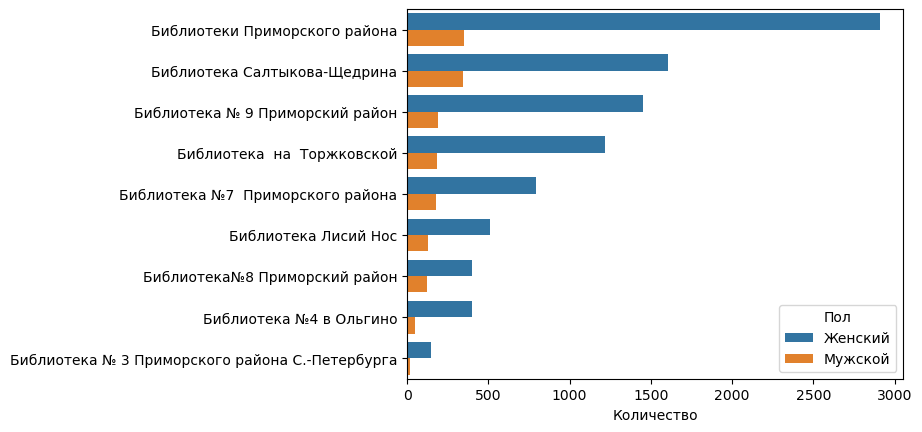

In [12]:
df_sex_for_plot = df_sex.copy()

# Перименуем столбцы для корректного отображения в легенде
df_sex_for_plot['sex'] = df_sex_for_plot['sex'].map({'female': 'Женский', 'male': 'Мужской'})

# Отсортируем по количеству по убыванию
df_sorted = df_sex_for_plot.sort_values(['sex', 'count'], ascending=[True, False])

# Построим график
ax = sns.barplot(data=df_sorted,
                 x='count',
                 y='group_name',
                 hue='sex')

ax.legend(title='Пол')
ax.set_xlabel('Количество')
ax.set_ylabel('')
plt.show()

---

## Возраст

#### Получаем возраст

In [13]:
def age_count(bdate):
    if not pd.isnull(bdate):  # Проверяем на Nan значения
        bdate_str = str(bdate)  # Переводим в строковый тип
        lst = bdate_str.split('.') # Создаем список для проверки даты рождения
        if len(lst) == 3: 
            bd = pd.to_datetime(bdate_str, format='%d.%m.%Y')  # Уточняем формат
            return datetime.date.today().year - bd.year
        else:
            return np.nan
    else:
        return np.nan         

In [14]:
subscribers_data['age'] = subscribers_data.bdate.apply(age_count)
subs_unique['age'] = subs_unique.bdate.apply(age_count)

In [15]:
display(subscribers_data.head())
display(subscribers_data.age.info())
display(subs_unique.age.info())

,id,sex,bdate,city,university,graduation,is_closed,group_name,age
0,1378,female,2.2,Санкт-Петербург,СПбГУ,2010.0,True,Библиотеки Приморского района,NaN
1,2006,female,18.8.1984,Санкт-Петербург,СПбГУКИ,2006.0,True,Библиотеки Приморского района,39.0
2,3269,male,26.12.1986,Санкт-Петербург,NaN,NaN,True,Библиотеки Приморского района,37.0
3,3326,male,6.5.1986,Санкт-Петербург,СПбГЭТУ (ЛЭТИ),2009.0,False,Библиотеки Приморского района,37.0
4,3357,female,13.8,Санкт-Петербург,NaN,NaN,False,Библиотеки Приморского района,NaN


<class 'pandas.core.series.Series'>
Int64Index: 10981 entries, 0 to 10980
Series name: age
Non-Null Count  Dtype  
--------------  -----  
4181 non-null   float64
dtypes: float64(1)
memory usage: 171.6 KB


None

<class 'pandas.core.series.Series'>
Int64Index: 9278 entries, 0 to 10980
Series name: age
Non-Null Count  Dtype  
--------------  -----  
3617 non-null   float64
dtypes: float64(1)
memory usage: 145.0 KB


None

#### Сортировка

Посмотрим на описательные статистики

In [16]:
subs_unique.age.describe()

count    3617.000000
mean       42.343931
std        17.184258
min        14.000000
25%        32.000000
50%        39.000000
75%        49.000000
max       122.000000
Name: age, dtype: float64

<AxesSubplot:xlabel='age', ylabel='Count'>

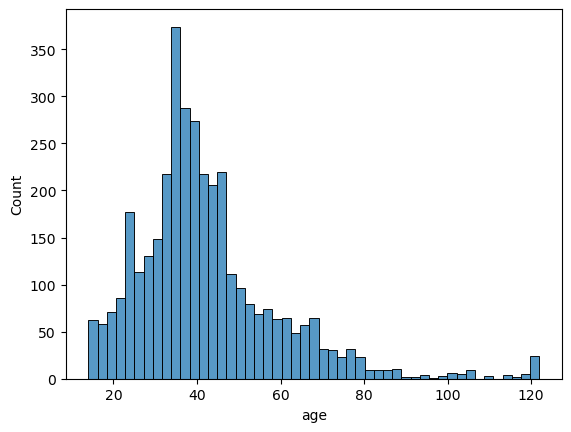

In [17]:
sns.histplot(subs_unique.age)

Видим, что присутствуют выбросы. В районе 90 лет идёт видимый спад, поэтому выберем, такой процентиль, который отсчёт слишком высокие значения. Им оказался 97 процентиль.

In [18]:
subs_age = subscribers_data.dropna(subset='age')
subs_age_unique = subs_unique.dropna(subset='age')
max_age = np.percentile(subs_age['age'], 97)

<AxesSubplot:xlabel='age', ylabel='Count'>

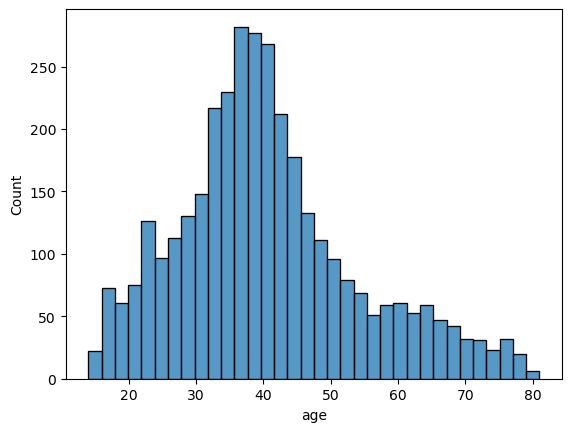

In [62]:
ax = sns.histplot(subs_age_unique.query('age <= @max_age').drop_duplicates(subset='id').age)
ax.set_xlabel('Возраст')
ax.set_ylabel('Количество наблюдений')
plt.show()

Посмотрим, сколько осталось наблюдений, после корректировки

In [20]:
subs_age = subs_age[subs_age['age'] <= max_age]
subs_age_unique = subs_age_unique[subs_age_unique['age'] <= max_age]
display(subs_age.age.info())
display(subs_age_unique.age.info())

<class 'pandas.core.series.Series'>
Int64Index: 4057 entries, 1 to 10980
Series name: age
Non-Null Count  Dtype  
--------------  -----  
4057 non-null   float64
dtypes: float64(1)
memory usage: 63.4 KB


None

<class 'pandas.core.series.Series'>
Int64Index: 3513 entries, 1 to 10980
Series name: age
Non-Null Count  Dtype  
--------------  -----  
3513 non-null   float64
dtypes: float64(1)
memory usage: 54.9 KB


None

#### Описательные статистики

In [21]:
subs_age_unique.age.describe()

count    3513.000000
mean       40.574153
std        13.734226
min        14.000000
25%        32.000000
50%        39.000000
75%        47.000000
max        81.000000
Name: age, dtype: float64

Посмотрим по группам

In [22]:
subs_age.groupby('group_name', as_index=False) \
                     .agg({'age': 'describe'}) \
                    .sort_values(by=[('age', 'count')], ascending=False)


group_name     age             \
                                                     count       mean   
8                    Библиотеки Приморского района  1183.0  41.312764   
2                     Библиотека Салтыкова-Щедрина   772.0  37.422280   
4                  Библиотека № 9 Приморский район   546.0  40.353480   
0                      Библиотека  на  Торжковской   496.0  44.540323   
6                Библиотека №7  Приморского района   367.0  39.754768   
1                             Библиотека Лисий Нос   253.0  44.707510   
7                    Библиотека№8 Приморский район   230.0  37.608696   
5                          Библиотека №4 в Ольгино   161.0  44.242236   
3  Библиотека № 3 Приморского района С.-Петербурга    49.0  44.775510   

                                             
         std   min   25%   50%    75%   max  
8  13.106174  14.0  33.0  40.0  49.00  81.0  
2  12.542655  15.0  28.0  36.0  43.25  78.0  
4  12.269959  15.0  34.0  39.0  46.00  78.0  
0  15.280620  15.0  35.0  41.0  55.25  81.0  
6  11.053759  15.0  33.0  38.0  44.00  76.0  
1  16.270818  15.0  34.0  42.0  57.00  79.0  
7  14.735037  14.0  26.0  35.5  44.00  81.0  
5  14.768114  15.0  36.0  40.0  54.00  81.0  
3  15.667463  16.0  35.0  44.0  59.00  74.0

#### Проверка распределения на нормальность

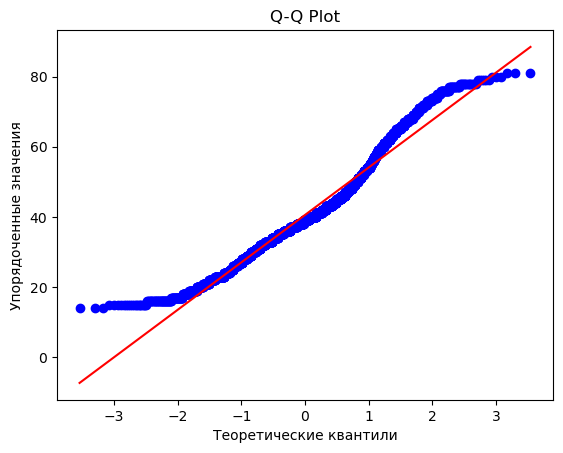

In [23]:
stats.probplot(subs_age_unique.age, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.xlabel("Теоретические квантили")
plt.ylabel("Упорядоченные значения")
plt.show()

In [24]:
# Проводим тест Шапиро-Уилка
statistic, p_value = stats.shapiro(subs_age_unique.age)

# Выводим результаты теста
print("Statistic:", statistic)
print("p-value:", p_value)

Statistic: 0.9651340246200562
p-value: 2.4002393044061746e-28


*График и тест Шапиро-Уилка (p-value > 0.05) показали, что распределение без выбросов в большую сторону можно считать нормальным*

In [25]:
# Выборка возрастов
sample = subs_age_unique["age"].dropna().values

# Размер выборки
sample_size = len(sample)

# Выборочное среднее и стандартное отклонение
sample_mean = np.mean(sample)
sample_std = np.std(sample, ddof=1)

# Уровень доверия - 95%
confidence_level = 0.95

# Рассчитываем стандартную ошибку
standard_error = sample_std / np.sqrt(sample_size)

# Рассчитываем критическое значение Z для уровня доверия
z_value = stats.norm.ppf(1 - (1 - confidence_level) / 2)

# Рассчитываем доверительный интервал
lower_bound = sample_mean - z_value * standard_error
upper_bound = sample_mean + z_value * standard_error

# Вывод результатов
print("Выборочное среднее:", sample_mean)
print("Стандартное отклонение выборки:", sample_std)
print("Доверительный интервал (нижняя граница, верхняя граница):", (lower_bound, upper_bound))

Выборочное среднее: 40.57415314545972
Стандартное отклонение выборки: 13.734226126185481
Доверительный интервал (нижняя граница, верхняя граница): (40.119988619011416, 41.02831767190802)


*При сохранении нормальности, средний возраст по охвату библиотечных групп будет находится в диапазоне от 40.11 до 41.02*

---

## Визуализация
Отобразим возраст и пол на графиках

#### Распределение возраста

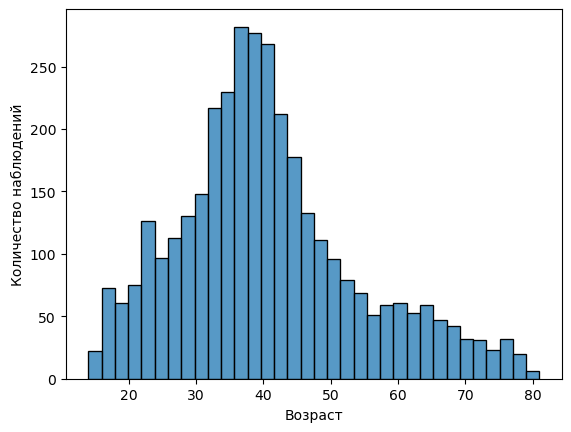

In [65]:
ax = sns.histplot(subs_age_unique.drop_duplicates(subset='id').age)

ax.set_xlabel('Возраст')
ax.set_ylabel('Количество наблюдений')
plt.show()

#### Возраст по группам

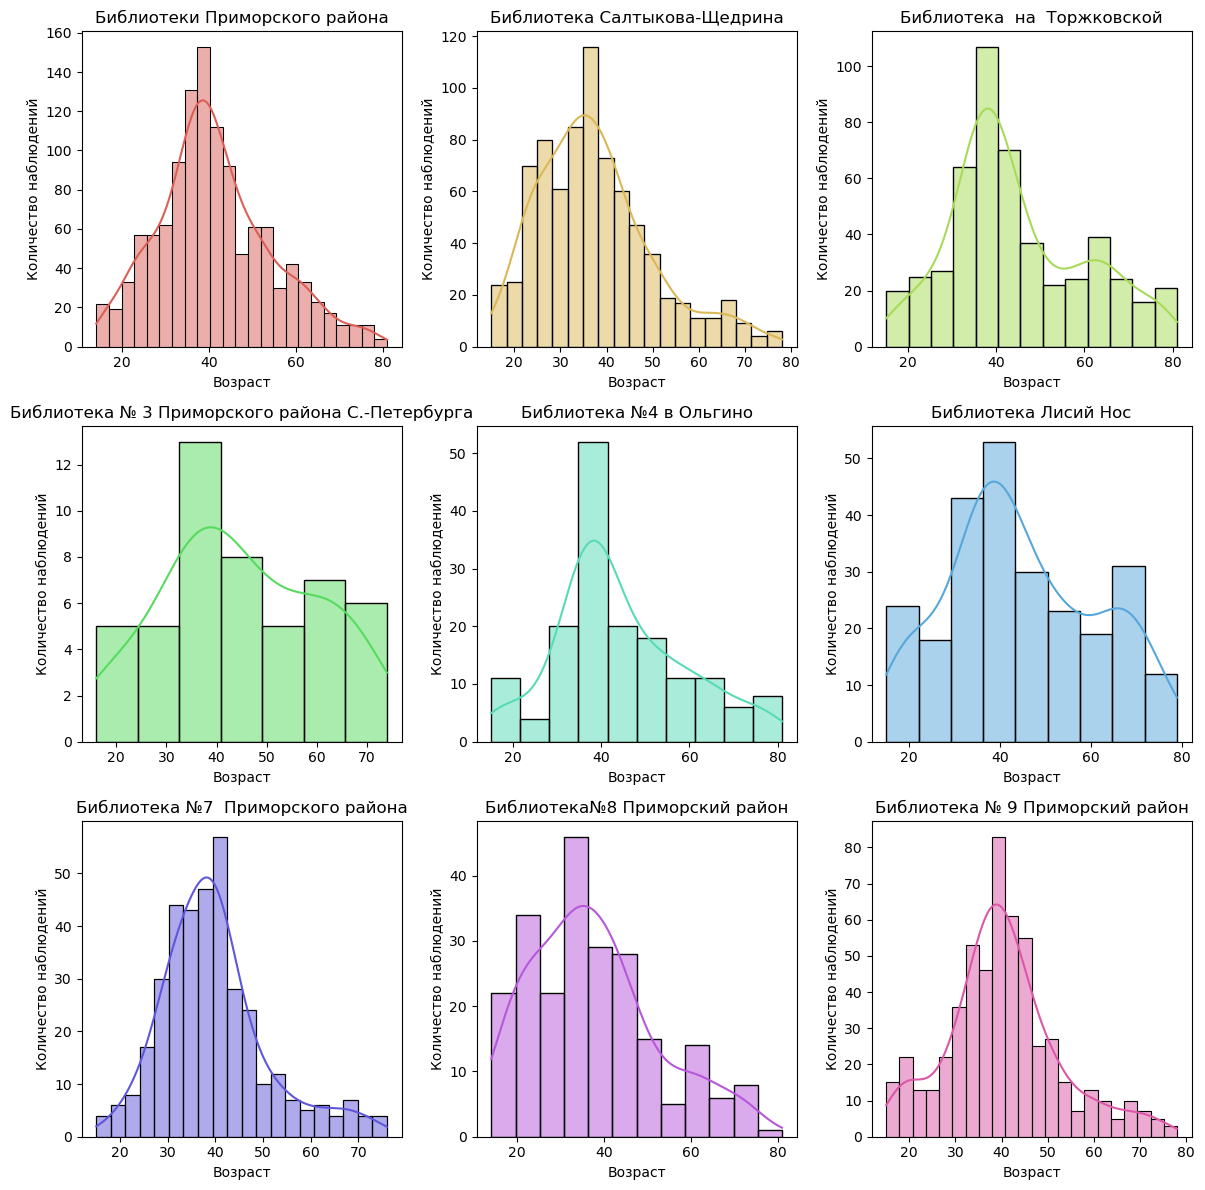

In [27]:
# Получаем уникальные группы
groups = subs_age['group_name'].unique()
num_groups = len(groups)

# Считаем количество рядов и колонок для сетки графиков
num_rows = (num_groups - 1) // 3 + 1
num_cols = min(num_groups, 3)

# Задаем сетку
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 4*num_rows))

# Задаем цвета
colors = sns.color_palette("hls", num_groups)

# Проходимся по каждой из уникальных групп
for i, group in enumerate(groups):
    row_idx = i // num_cols
    col_idx = i % num_cols

    # Создаём график распределения по возрасту
    sns.histplot(subs_age.query('group_name == @group')['age'], kde=True, ax=axs[row_idx, col_idx], color=colors[i])

    # Задаем заголовок и подписи
    axs[row_idx, col_idx].set_title(group)
    axs[row_idx, col_idx].set_xlabel('Возраст')
    axs[row_idx, col_idx].set_ylabel('Количество наблюдений')

# Чтобы графики не наезжали друг на друга
plt.tight_layout()

# Отображаем графики
plt.show()


#### Возраст и пол

Text(0, 0.5, 'Возраст')

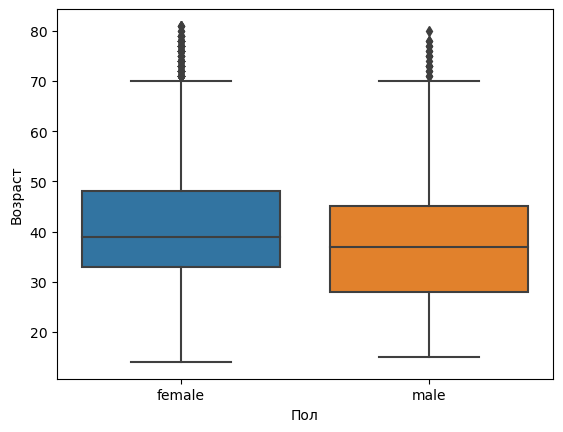

In [28]:
ax = sns.boxplot(data=subs_age_unique,
            x='sex',
            y='age')
ax.set_xlabel('Пол')
ax.set_ylabel('Возраст')

---

### Город
Посмотрим на то, какой город указан у подписчиков

In [29]:
subs_age_unique.city.value_counts().head(10)

Санкт-Петербург    2197
Москва               93
Новосибирск          14
Омск                 12
Нижний Новгород      11
Екатеринбург         11
Челябинск             9
Пермь                 8
Ярославль             8
Красноярск            8
Name: city, dtype: int64

---

### Университет
Теперь посмотрим, в каких университетах учатся/учились подписчики

In [30]:
subs_unique.university.value_counts().head(10)

СПбГУ                                     428
РГПУ им. Герцена                          182
СПбГЭУ (ранее ФИНЭК, ИНЖЭКОН, СПбГУСЭ)    156
СПбГУКИ                                   145
СПбГИК (бывш. СПбГУКИ)                    143
РГПУ им. А. И. Герцена                    115
СПбГЭТУ (ЛЭТИ)                            104
СПбГПУ Политех                             90
СПбПУ Петра Великого (Политех)             77
СПбГУТ им. Бонч-Бруевича                   44
Name: university, dtype: int64

Видим, что некоторые университеты написаны по-разному. Напишем функции, чтобы привести к одинаковых значениям

In [41]:
def uni_correct(input_string):
    if not pd.isnull(input_string):
        if 'СПбГУКИ' in input_string or 'СПбГИК' in input_string:
            return 'СПбГИК'
        elif 'Политех' in input_string:
            return 'Политех'
        elif input_string != 'Университет ИТМО':
            space_index = input_string.find(' ')
            if space_index != -1:
                sliced_string = input_string[:space_index]
                return sliced_string
            else:
                # Если пробел не найден, возвращаем исходную строку
                return input_string
        else:
            return input_string
    else:
        return input_string

In [42]:
# Сохраняем в отдельный датасет подписчиков с указаным университетом
subs_university_unique = subs_unique.dropna(subset='university').copy()
# Применяем функцию
subs_university_unique['university'] = subs_university_unique.university.apply(uni_correct)

#### Топ-5 университетов

In [43]:
top_5_universities_unique = subs_university_unique.university.value_counts().head()
top_5_universities_unique

СПбГУ      456
СПбГИК     319
РГПУ       298
СПбГЭУ     201
Политех    182
Name: university, dtype: int64

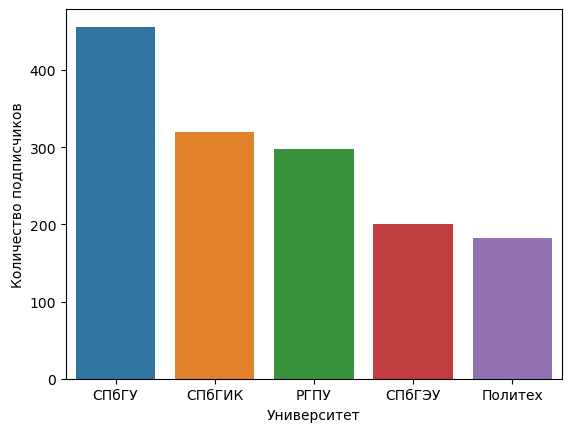

In [44]:
ax = sns.barplot(x=top_5_universities_unique.index, y=top_5_universities_unique.values)
ax.set_xlabel('Университет')
ax.set_ylabel('Количество подписчиков')
plt.show()

#### Популярные университеты по группам

In [35]:
# Обработаем датасет со всеми подписчиками

subs_university = subscribers_data.dropna(subset='university').copy()
subs_university['university'] = subs_university.university.apply(uni_correct)

In [36]:
# Считаем, как часто какие университеты встречаются в каждой группе
group_university_counts = subs_university.groupby(['group_name', 'university']) \
                                        .size() \
                                        .reset_index(name='count')
# Фильтрация только топ-5 университетов для каждой группы
top_5_universities = group_university_counts.groupby('group_name') \
                                            .apply(lambda x: x.nlargest(5, 'count')) \
                                            .reset_index(drop=True)

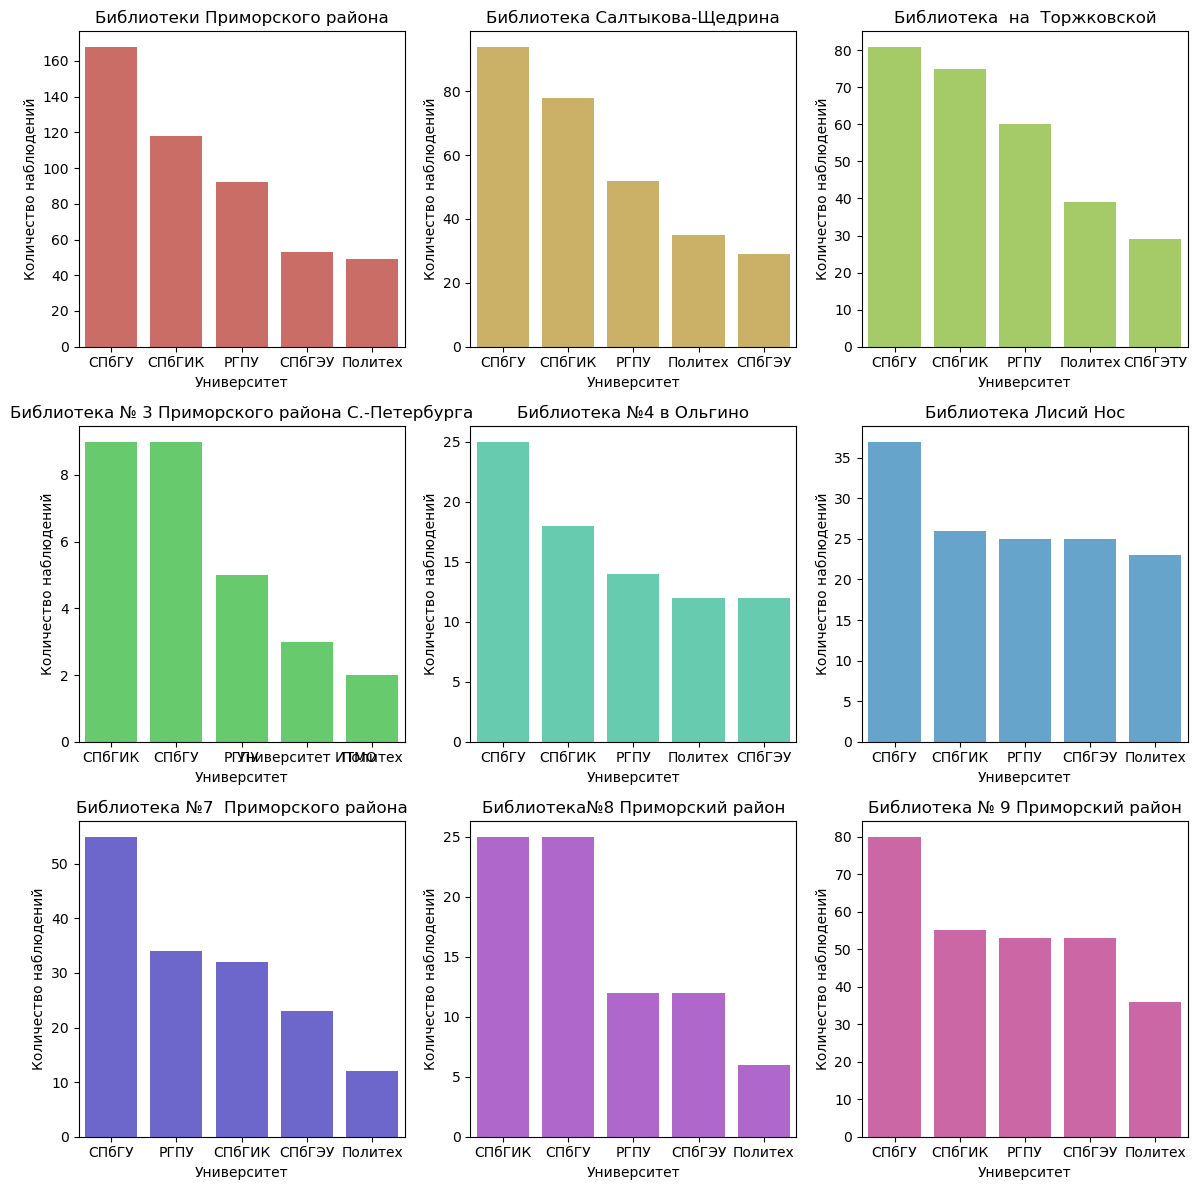

In [69]:
# Получаем уникальные группы
groups = subs_age['group_name'].unique()
num_groups = len(groups)

# Считаем количество рядов и колонок для сетки графиков
num_rows = (num_groups - 1) // 3 + 1
num_cols = min(num_groups, 3)

# Задаем сетку
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 4*num_rows))

# Задаем цвета
colors = sns.color_palette("hls", num_groups)

# Проходимся по каждой из уникальных групп
for i, group in enumerate(groups):
    row_idx = i // num_cols
    col_idx = i % num_cols

    # Создаём график распределения по возрасту
    sns.barplot(data=top_5_universities.query('group_name == @group'),
                x='university',
                y='count', 
                ax=axs[row_idx, col_idx], color=colors[i])

    # Задаем заголовок и подписи
    axs[row_idx, col_idx].set_title(group)
    axs[row_idx, col_idx].set_xlabel('Университет')
    axs[row_idx, col_idx].set_ylabel('Количество наблюдений')

# Чтобы графики не наезжали друг на друга
plt.tight_layout()

# Отображаем графики
plt.show()


#### Студенты
Предположим, что студентами можно считать всех, чей возраст младше 28 и у кого указан университет

In [77]:
subs_university_unique.query('age <= 28 and graduation.isna()').university.value_counts()

СПбГИК       9
СПбГУ        8
РГПУ         7
СПбГЭТУ      6
Политех      5
            ..
МГПУ         1
上海政法学院       1
КИМ          1
КГАСУ\r\n    1
Академия     1
Name: university, Length: 65, dtype: int64

Таких совсем мало, поэтому этот пункт мы анализировать не будем

---

## Сохранение
Выгрузим получившийся итоговый датасет для использования в кластеризации и визуализации в Power BI

In [45]:
subscribers_data['university'] = subscribers_data.university.apply(uni_correct)

In [48]:
subscribers_data.to_csv('subscribers_data_final.csv')